In [1]:
import csv
import datetime
import operator
import os
import os.path

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd

from io import StringIO
from matplotlib import rcParams
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA


# Don't cut xlabel when saving .fig
rcParams.update({'figure.autolayout': True})

# Convert datetime for matplotlib
register_matplotlib_converters()

In [2]:
# Find number of channels in house_1
def load_REDD_house(i_house):
    """Loads data from a REDD dataset house. The 'low_freq' directory must be in the root of the project.
    
    Args:
        i_house (int): index of the house.
    
    Returns:
        (list, DataFrame): tuple of a list of each channel consumption data,
        and a DataFrame of the labels identifying the appliance of each channel.
    """
    path = 'low_freq/house_{}/'.format(i_house)
    num_channels = len([name for name in os.listdir(path) if os.path.isfile(os.path.join(path, name))]) - 1

    # Load consumption data
    channels = []
    for i in range(num_channels):
        ch = pd.read_csv(path + 'channel_{}.dat'.format(i + 1), delimiter=' ', names=['t', 'pot'])
        ch.t = pd.to_datetime(ch.t, unit='s')
        channels.append(ch)

    # Load labels
    labels = pd.read_csv(path + 'labels.dat', delimiter=' ', names=['i', 'name'])
    
    return channels, labels

#channels, labels = load_REDD_house(1)
#print(labels)
#print(channels)

In [3]:
def load_SMART_house(year):
    """Loads data from a SMART dataset house. The 'HomeA' directory must be in the root of the project.
    
    Args:
        year (str): desired year to be loaded.
    
    Returns:
        (list, DataFrame): tuple of a list of each channel consumption data,
        and a DataFrame of the labels identifying the appliance of each channel.
    """
    path = 'HomeA/{}/'.format(year)
    
    labels = pd.DataFrame(columns=['name'])
    channels = list()
    # Load data for each meter (2-4)
    for i in range(2, 5):
        meter_data = pd.read_csv(path + 'HomeA-meter{}_{}.csv'.format(i, year), delimiter=',')
        label = pd.DataFrame(list(meter_data)[3:], columns=['name'])
        labels = labels.append(label, ignore_index=True)
        t = pd.to_datetime(meter_data.iloc[:, 0]).rename('t')
        t = pd.to_datetime(t, unit='s')
        
        # Add each channel as a DataFrame with columns ['t', 'pot']
        for i in range(3, len(meter_data.columns)):
            channel = pd.DataFrame(t)
            channel['pot'] = meter_data.iloc[:,i]
            channel.loc[:,'pot'] *= 1e3  # Convert from kW to W
            channels.append(channel)
    
    labels['name'] = labels['name'].astype(str).str[:-5]  # Remove ' [kW]' from string
    return channels, labels

channels, labels = load_SMART_house('2016')
print(labels)
print(channels)

                           name
0                    FurnaceHRV
1                 CellarOutlets
2                WashingMachine
3                   FridgeRange
4            DisposalDishwasher
5                 KitchenLights
6                BedroomOutlets
7                 BedroomLights
8                 MasterOutlets
9                  MasterLights
10                DuctHeaterHRV
11                ElectricRange
12                        Dryer
13          GarageMudroomLights
14            DiningRoomOutlets
15               MudroomOutlets
16            MasterBathOutlets
17                GarageOutlets
18       BasementOutdoorOutlets
19             KitchenDenLights
20          MasterBedBathLights
21                MasterOutlets
22             DenOutdoorLights
23                   DenOutlets
24           RearBasementLights
25           KitchenOutletsEast
26          KitchenOutletsSouth
27  DishwasherDisposalSinkLight
28                 Refrigerator
29                    Microwave
30      

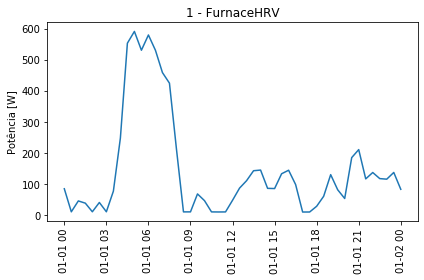

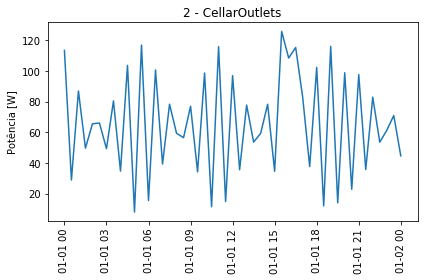

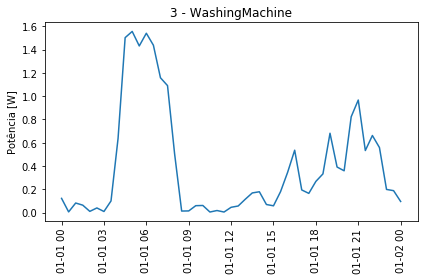

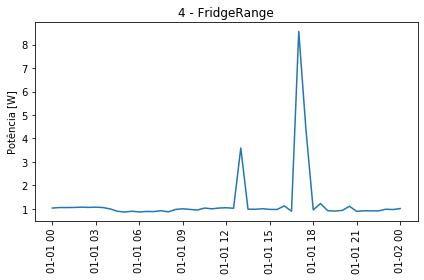

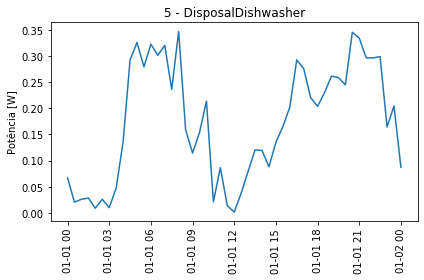

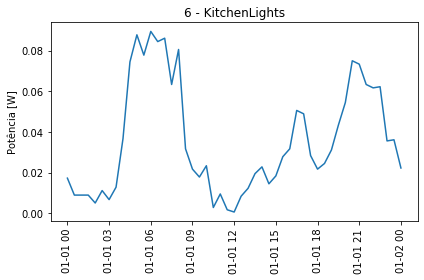

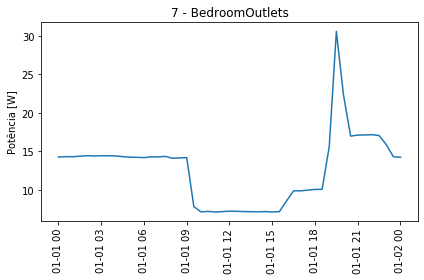

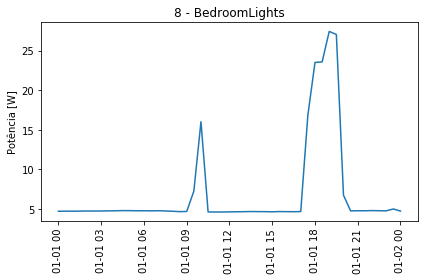

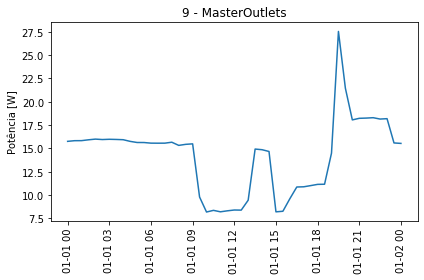

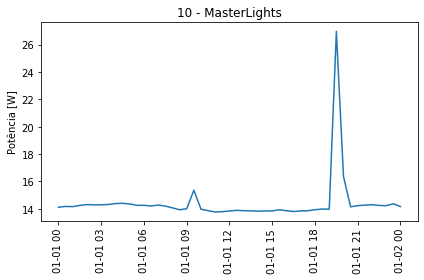

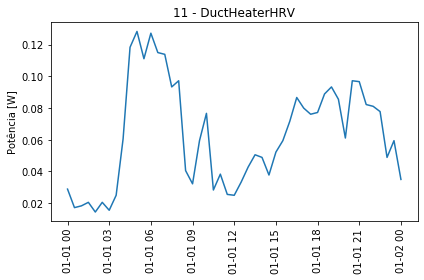

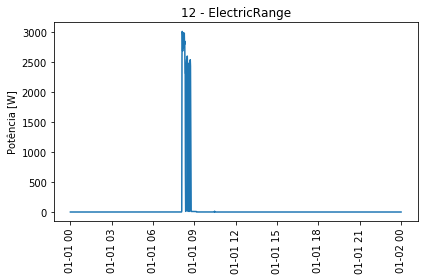

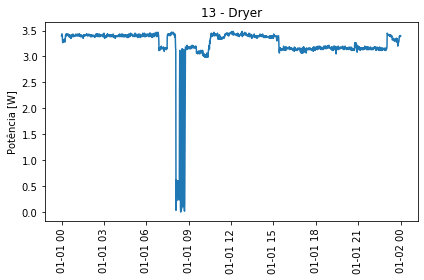

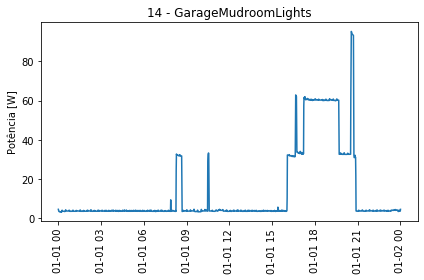

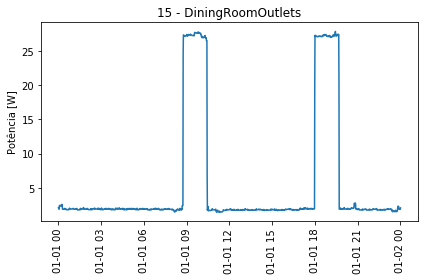

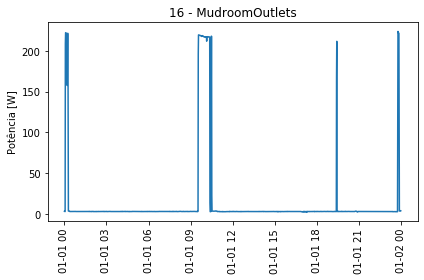

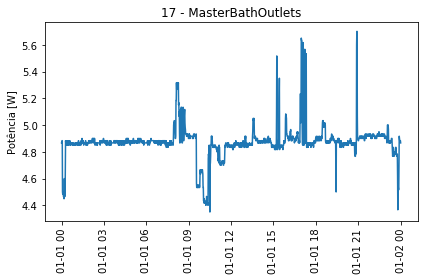

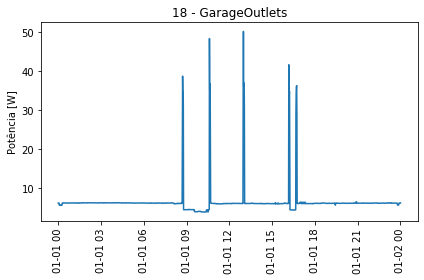

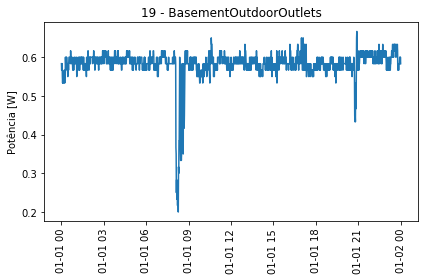

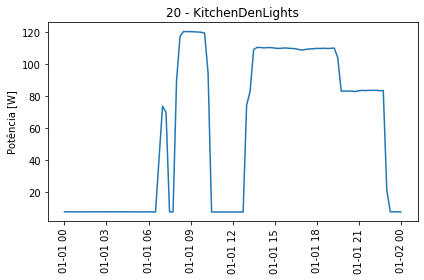

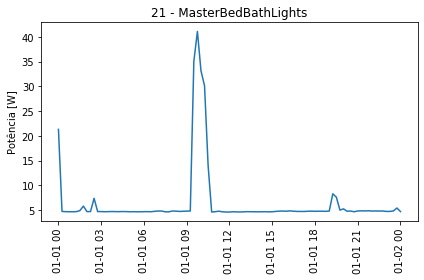

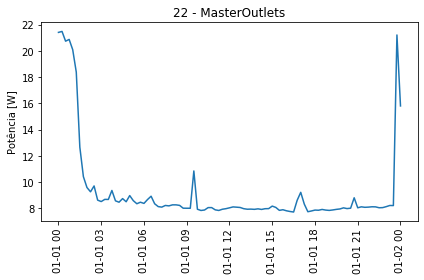

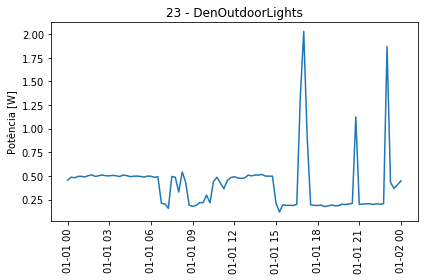

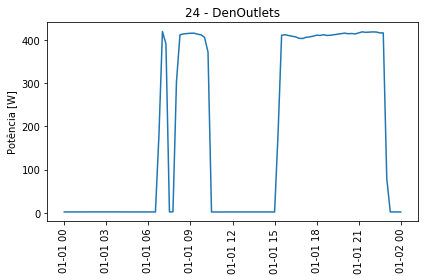

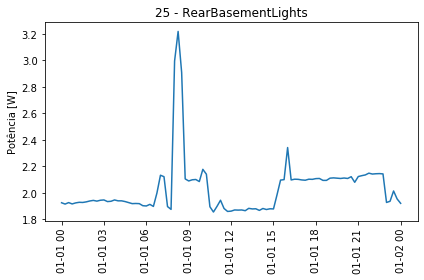

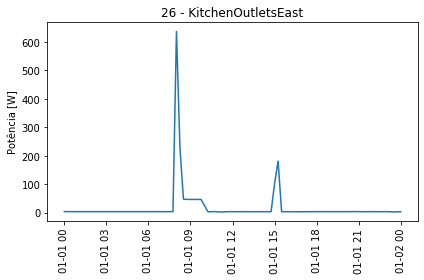

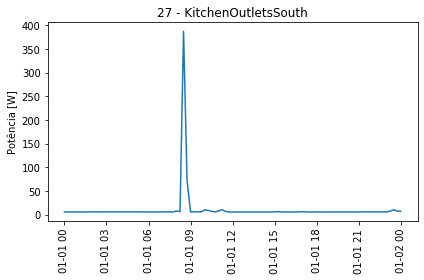

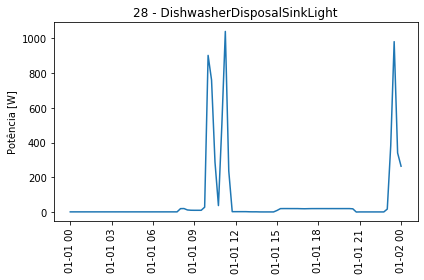

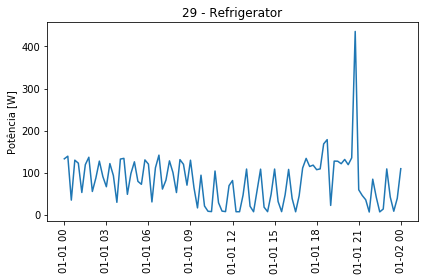

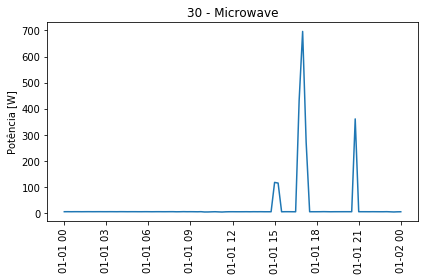

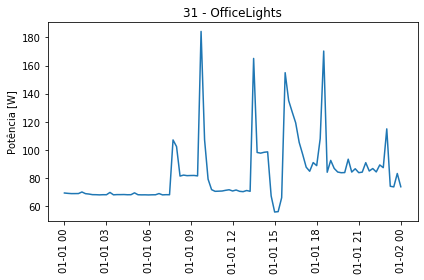

In [4]:
def qry_pot_channel(i_channel, start, end):
    """Runs a query for the potency consumption in a channel in the specified period.
    
    Args:
        i_channel(int): index of the channel.
        start (str): start of the period as "YYYY-MM-DD hh:mm:ss".
        end (str): end of the period as "YYYY-MM-DD hh:mm:ss".
    
    Returns:
        str: csv of the query as [index, time, consumption].
    """
    if i_channel < 0 or i_channel >= len(channels):
        raise Exception('Channel number should be 0-{}. The value was {}'.format(len(labels) - 1, i_channel))
    
    # Select the desired period from channel
    ch = channels[i_channel]
    mask = (ch.t >= start) & (ch.t < end)
    ch_period = ch.loc[mask]
    
    # Return query as csv string
    return ch_period.to_csv()


# Plot data from day 2016-01-01
for i in range(len(channels)):
    query = qry_pot_channel(i, '2016-01-01', '2016-01-02 00:00:05')
    
    # Convert query string to pandas.DataFrame
    ch = pd.read_csv(StringIO(query), delimiter=',', header=0, usecols=[1, 2])
    ch.t = pd.to_datetime(ch.t)
    
    # Plot query results
    plt.plot(ch.t, ch.pot)
    plt.title(str(i + 1) + " - " + labels.iloc[i]['name'])
    plt.ylabel('Potência [W]')
    plt.xticks(rotation=90)
    plt.savefig('plot/day-01-01/channel_{}.png'.format(i + 1))
    plt.show()

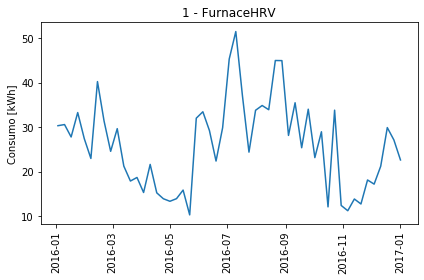

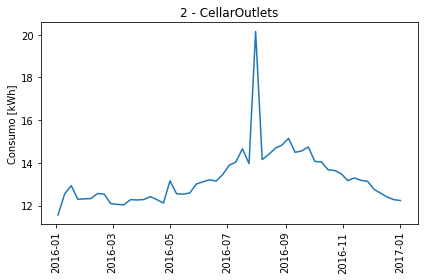

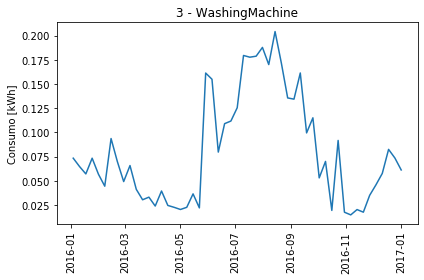

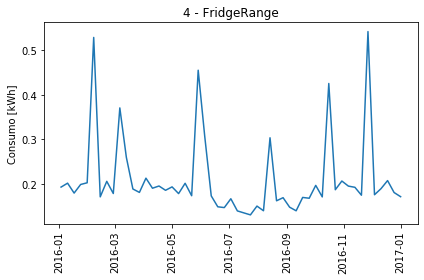

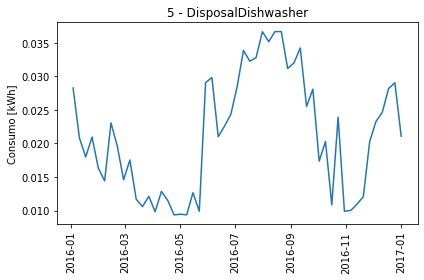

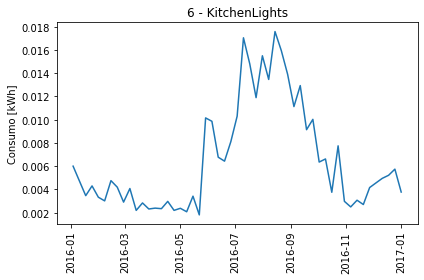

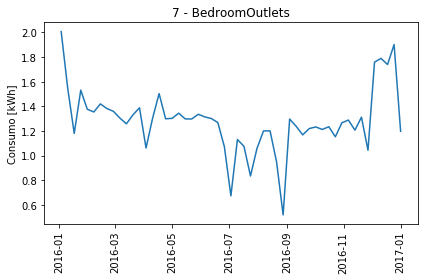

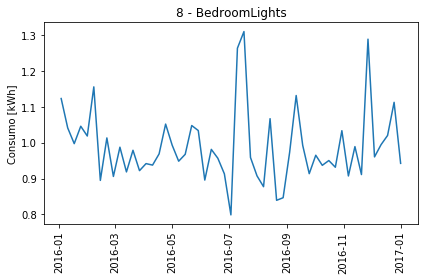

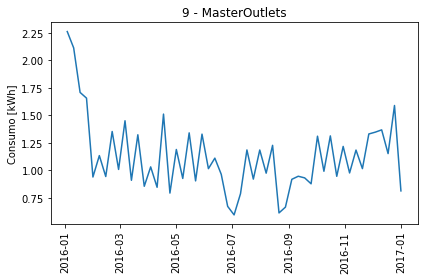

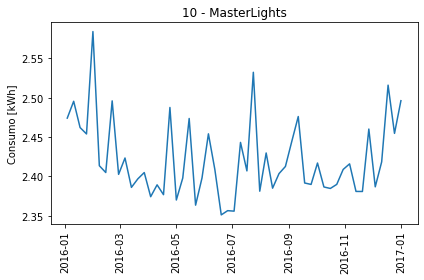

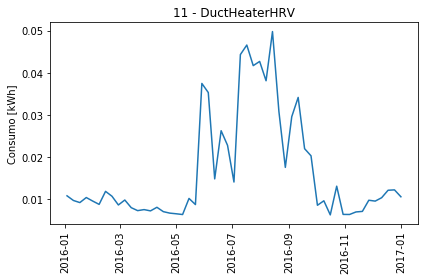

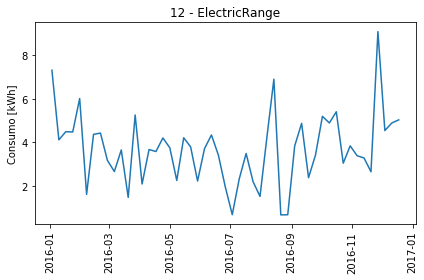

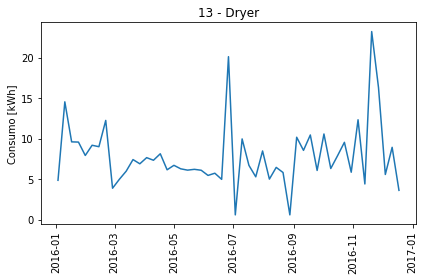

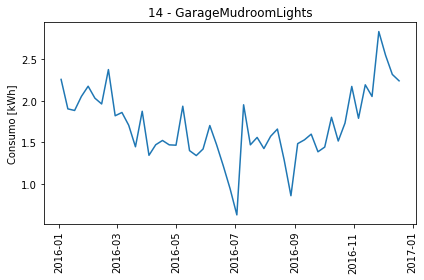

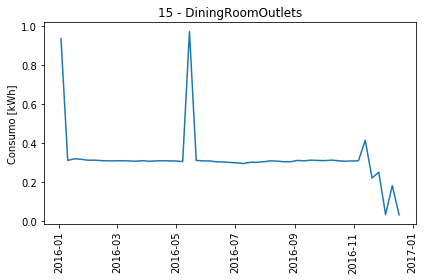

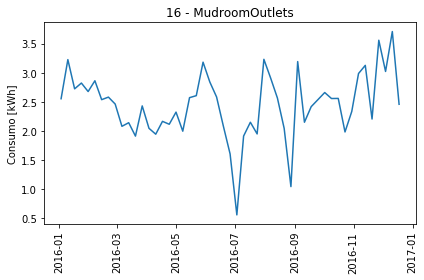

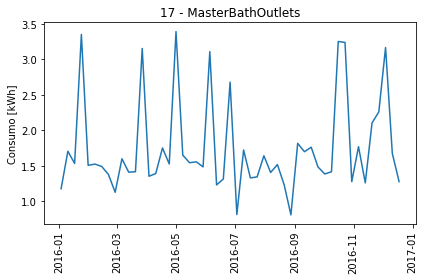

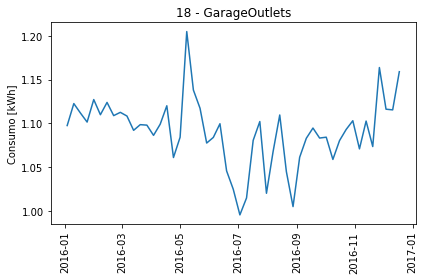

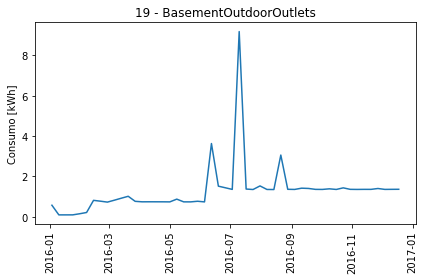

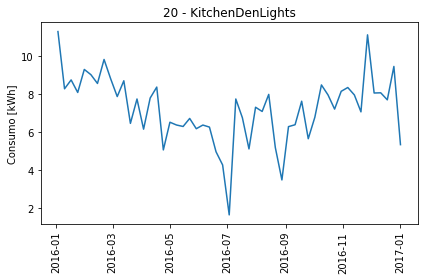

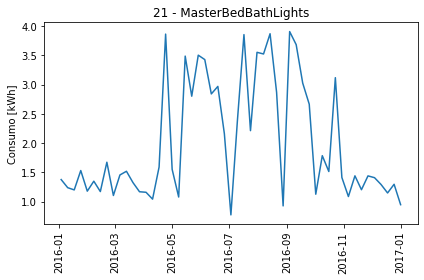

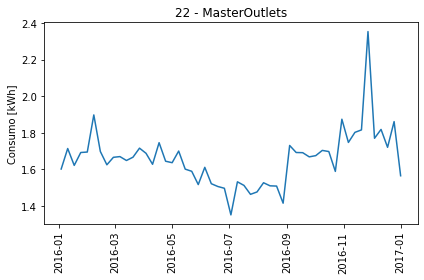

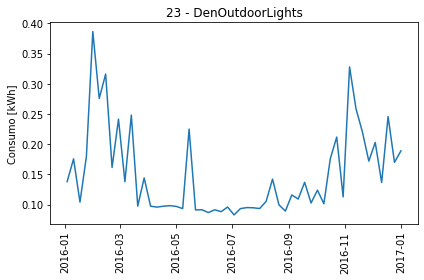

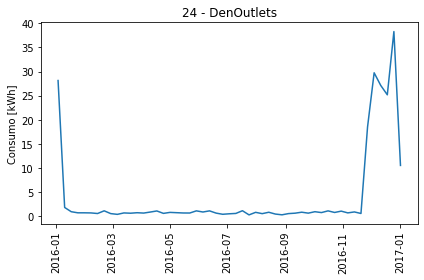

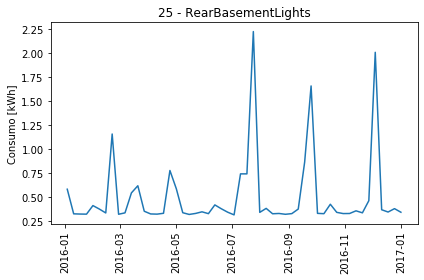

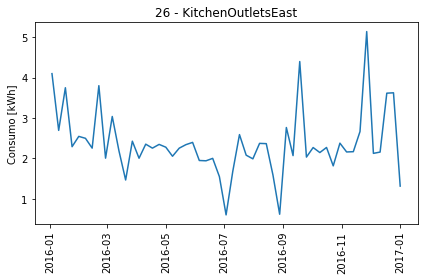

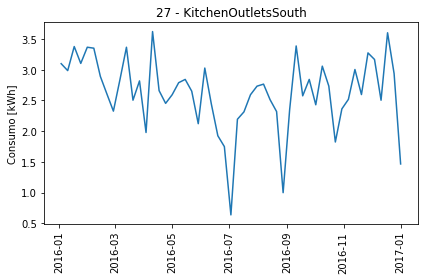

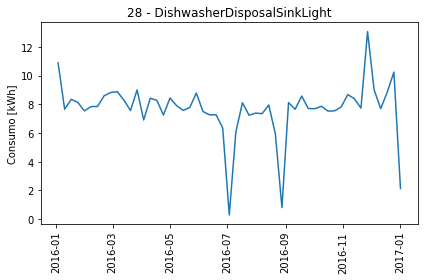

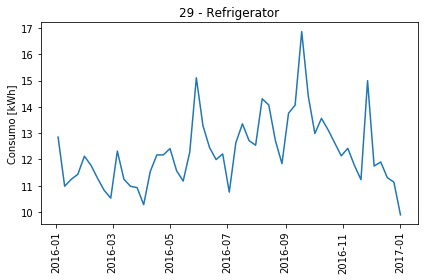

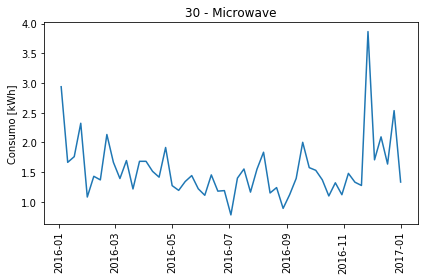

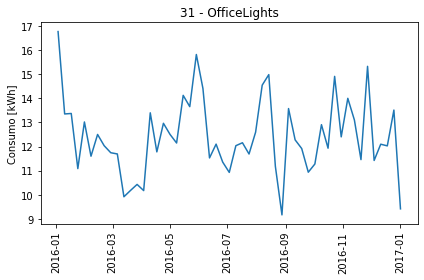

In [5]:
def qry_total_cons_channel(i_channel, start, end, frequency):
    """Runs a query for the total consumption in a channel in the specified period.
    
    Args:
        i_channel (int): index of the channel.
        start (str): start of the period as "YYYY-MM-DD hh:mm:ss".
        end (str): end of the period as "YYYY-MM-DD hh:mm:ss".
        frequency (str): Period of consumption. 'D', 'W', or 'M' (daily, weekly or monthly).
    
    Returns:
        str: csv of the query as [index, date, consumption].
    """
    if i_channel < 0 or i_channel >= len(channels):
        raise Exception('Channel number should be 1-{}. The value was {}'.format(len(labels), i_channel))
    
    # Select the desired period from channel
    ch = channels[i_channel]
    mask = (ch.t >= start) & (ch.t < end)
    ch_period = ch.loc[mask]
    
    # Find mean consumption by day, week, or month
    cons = ch_period.copy()
    cons = cons.set_index('t')
    cons = cons.groupby(pd.Grouper(freq=frequency)).mean().dropna(how='all')
    cons = cons.reset_index()
    cons = pd.concat([cons.t, cons.pot], axis=1)
    cons.columns = ['t', 'energy']
    
    # Remove days without consumption data
    cons = cons[~cons.energy.isna()]
    
    # Convert to kWh
    period_hours = 24
    if frequency == 'W':
        period_hours *= 7
    if frequency == 'M':
        period_hours *= 30
    cons.energy = cons.energy * period_hours / 1e3
    
    # Return query as csv string
    return cons.to_csv()


# Plot daily consumption for each channel for all period available
day_cons = []
for i in range(len(channels)):
    query = qry_total_cons_channel(i, '2016-01-01', '2016-12-31', 'W')
    
    cons = pd.read_csv(StringIO(query), delimiter=',', header=0, usecols=[1, 2])
    cons.t = pd.to_datetime(cons.t)
    
    day_cons.append(cons)
    plt.plot(cons.t, cons.energy)
    plt.title(str(i + 1) + " - " + labels.iloc[i]['name'])
    plt.ylabel('Consumo [kWh]')
    plt.xticks(rotation=90)
    plt.savefig('plot/daily/channel_{}.png'.format(i + 1))
    plt.show()

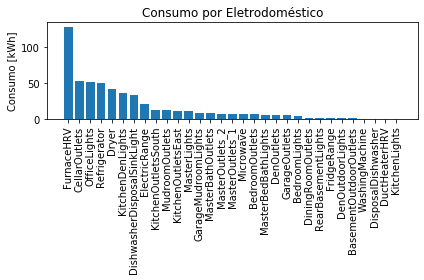

In [6]:
def qry_total_cons_all(start, end, percentage=False):
    """Runs a query for the total consumption in each channel in the specified period.
    
    Args:
        start (str): start of the period as "YYYY-MM-DD hh:mm:ss".
        end (str): end of the period as "YYYY-MM-DD hh:mm:ss".
        percentage (bool): if true, return percentage of total consumption of each channel.
    
    Returns:
        str: csv of the query as [label; total consumption].
    """
    total_cons = {}
    for i in range(0, len(channels)):
        # Select the desired period from channel
        ch = channels[i]
        mask = (ch.t >= start) & (ch.t < end)
        ch_period = ch.loc[mask]
        
        # Find mean consumption
        cons = ch_period.pot.mean()
        
        # Convert to kWh
        t1 = pd.to_datetime(start)
        t2 = pd.to_datetime(end)
        cons *= pd.Timedelta(t2 - t1).total_seconds() / (1e3 * 3600)
        
        # Add total consumption of channel i to hash map
        appliance_name = labels.iloc[i]['name']
        if appliance_name != 'mains':
            if appliance_name not in total_cons:
                total_cons[appliance_name] = cons
            else:
                total_cons[appliance_name + '_1'] = total_cons.pop(appliance_name)
                total_cons[appliance_name + '_2'] = cons
    
    if percentage == True:
        sum = 0
        for key, value in total_cons.items():
            sum += value
        for key, value in total_cons.items():
            total_cons[key] /= sum
    
    sorted_cons = sorted(total_cons.items(), key=operator.itemgetter(1), reverse=True)
    
    result = ','.join([item[0] for item in sorted_cons]) + '\n'
    result += ','.join([str(item[1]) for item in sorted_cons])
    return result

start_date = pd.to_datetime('2016-01-01')
end_date = start_date + pd.to_timedelta('30 days')
query = qry_total_cons_all(start_date, end_date, percentage=False)

f = StringIO(query)
qry_reader = csv.reader(f, delimiter=',')
sorted_cons = []
for row in qry_reader:
    sorted_cons.append(row)

for i in range(len(sorted_cons[1])):
    sorted_cons[1][i] = float(sorted_cons[1][i])

plt.title('Consumo por Eletrodoméstico')
plt.bar(sorted_cons[0], sorted_cons[1])
plt.ylabel('Consumo [kWh]')
plt.xticks(rotation=90)
plt.savefig('plot/day-05-01/by_channel.png')

In [7]:
# ARMA and ARIMA forecast
days_predicted = 30
#i_channel = 5

def get_aggr_cons(start, end, frequency):
    """Runs a query for the aggregated consumption in all channels in the specified period.
    
    Args:
        start (str): start of the period as "YYYY-MM-DD hh:mm:ss".
        end (str): end of the period as "YYYY-MM-DD hh:mm:ss".
        frequency (str): Period of consumption. 'D', 'W', or 'M' (daily, weekly or monthly).
    
    Returns:
        str: csv of the query as [index, date, daily consumption].
    """
    periods = (pd.to_datetime(end) - pd.to_datetime(start)).days
    t = pd.date_range(start, periods=periods, freq=frequency)
    energy = pd.DataFrame(0, index=np.arange(periods), columns=['energy'])
    aggr_cons = pd.DataFrame([t, energy]).transpose()
    aggr_cons.columns = ['t', 'energy']
    aggr_cons.t = pd.to_datetime(aggr_cons.t)
    aggr_cons.energy = 0
    
    for i in range(len(channels)):
        # Select the desired period from channel
        ch = channels[i]
        mask = (ch.t >= start) & (ch.t < end)
        ch_period = ch.loc[mask]

        # Find mean consumption by day, week, or month
        cons = ch_period.copy()
        cons = cons.set_index('t')
        cons = cons.groupby(pd.Grouper(freq=frequency)).mean().dropna(how='all')
        cons = cons.reset_index()
        cons = pd.concat([cons.t, cons.pot], axis=1)
        cons.columns = ['t', 'energy']

        # Remove days without consumption data
        cons = cons[~cons.energy.isna()]

        # Convert to kWh
        period_hours = 24
        if frequency == 'W':
            period_hours *= 7
        if frequency == 'M':
            period_hours *= 30
        cons.energy = cons.energy * period_hours / 1e3
        
        aggr_cons['energy'] += cons.energy
    
    return aggr_cons


test = get_aggr_cons('2016-01-01', '2016-06-01', 'D')
#query = qry_total_cons_channel(i_channel, '2016-01-17', '2016-05-25', 'D')
#cons = pd.read_csv(StringIO(query), delimiter=',', header=0, usecols=[1, 2])
#cons.t = pd.to_datetime(cons.t)

#test = cons.iloc[:15, :]
test.t = test.t.dt.date

date = test.t.iloc[-1]
predict_dates = []
for i in range(days_predicted + 1):
    predict_dates.append(date)
    date += datetime.timedelta(days=1)

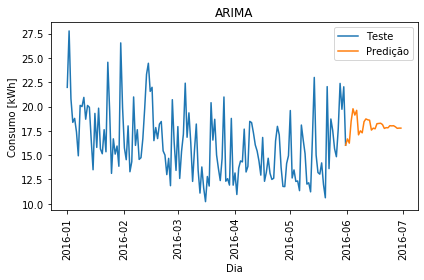

In [10]:
def qry_ARIMA(days_predicted, pdq):
    """Runs a query for the forecast consumption using an ARIMA model.
    
    Args:
        days_predicted (int): number of days to forecast.
        pdq (iterable): order of the model parameters.
    
    Returns:
        str: csv of the query as [index, date, daily forecasted consumption].
    """
    model = ARIMA(test.energy, pdq)
    model_fit = model.fit(disp=0)
    predicted = model_fit.forecast(days_predicted)
    
    # Add daily consumption of current day
    predict_cons = np.insert(predicted[0], 0, test.energy.iloc[-1])
    
    # Convert to pandas.DataFrame
    result = pd.DataFrame(np.transpose([predict_dates, predict_cons]))
    result.columns = ['t', 'energy']
    
    return result.to_csv()


# Plot forecast for 30 days aggregated consumption with ARIMA
query = qry_ARIMA(days_predicted, (7, 1, 2))
predict = pd.read_csv(StringIO(query), delimiter=',', header=0, usecols=[1, 2])
predict.t = pd.to_datetime(predict.t)

plt.title('ARIMA')
plt.plot(test.t.values, test.energy.values)
plt.plot(predict.t, predict.energy)
plt.legend(('Teste', 'Predição'))
plt.ylabel('Consumo [kWh]')
plt.xlabel('Dia')
plt.xticks(rotation=90)
plt.savefig('plot/ARIMA/arima210.png')

/home/tiago/anaconda3/envs/my_env/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


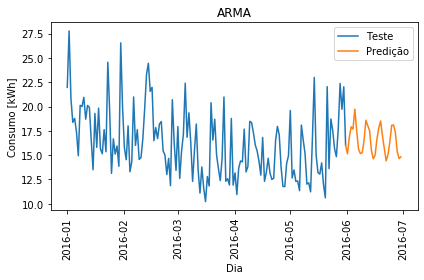

In [11]:
query = qry_ARIMA(days_predicted, (8, 0, 7))
predict = pd.read_csv(StringIO(query), delimiter=',', header=0, usecols=[1, 2])
predict.t = pd.to_datetime(predict.t)

plt.title('ARMA')
plt.plot(test.t.values, test.energy.values)
plt.plot(predict.t, predict.energy)
plt.legend(('Teste', 'Predição'))
plt.ylabel('Consumo [kWh]')
plt.xlabel('Dia')
plt.xticks(rotation=90)
plt.savefig('plot/ARIMA/arma01.png')